In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model, tree, ensemble, svm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import xgboost
import pickle
import json

In [4]:
# Load and explore data
data = pd.read_csv('traffic volume.csv')
print(data.head())
print(data.describe())
print(data.info())


  holiday    temp  rain  snow weather        date      Time  traffic_volume
0     NaN  288.28   0.0   0.0  Clouds  02-10-2012  09:00:00            5545
1     NaN  289.36   0.0   0.0  Clouds  02-10-2012  10:00:00            4516
2     NaN  289.58   0.0   0.0  Clouds  02-10-2012  11:00:00            4767
3     NaN  290.13   0.0   0.0  Clouds  02-10-2012  12:00:00            5026
4     NaN  291.14   0.0   0.0  Clouds  02-10-2012  13:00:00            4918
               temp          rain          snow  traffic_volume
count  48151.000000  48202.000000  48192.000000    48204.000000
mean     281.205351      0.334278      0.000222     3259.818355
std       13.343675     44.790062      0.008169     1986.860670
min        0.000000      0.000000      0.000000        0.000000
25%      272.160000      0.000000      0.000000     1193.000000
50%      282.460000      0.000000      0.000000     3380.000000
75%      291.810000      0.000000      0.000000     4933.000000
max      310.070000   9831.30000

In [5]:
# Handle missing values
data['temp'].fillna(data['temp'].mean(), inplace=True)
data['rain'].fillna(data['rain'].mean(), inplace=True)
data['snow'].fillna(data['snow'].mean(), inplace=True)

C:\Users\LakshmanReddy\AppData\Local\Temp\ipykernel_2640\2942024604.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['temp'].fillna(data['temp'].mean(), inplace=True)
C:\Users\LakshmanReddy\AppData\Local\Temp\ipykernel_2640\2942024604.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [6]:
from collections import Counter
print(Counter(data['weather']))
data['weather'].fillna("Clouds", inplace=True)

Counter({'Clouds': 15144, 'Clear': 13383, 'Mist': 5942, 'Rain': 5665, 'Snow': 2875, 'Drizzle': 1818, 'Haze': 1359, 'Thunderstorm': 1033, 'Fog': 912, nan: 49, 'Smoke': 20, 'Squall': 4})


C:\Users\LakshmanReddy\AppData\Local\Temp\ipykernel_2640\2814027340.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['weather'].fillna("Clouds", inplace=True)


<Axes: xlabel='traffic_volume', ylabel='Count'>

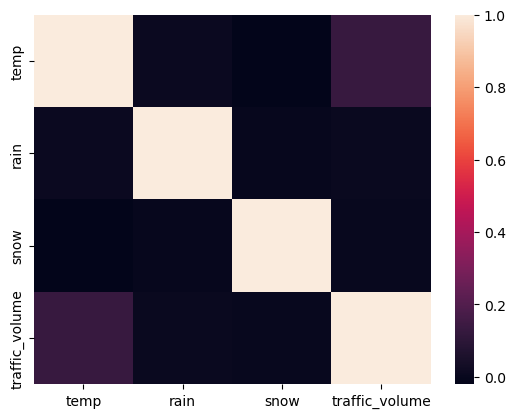

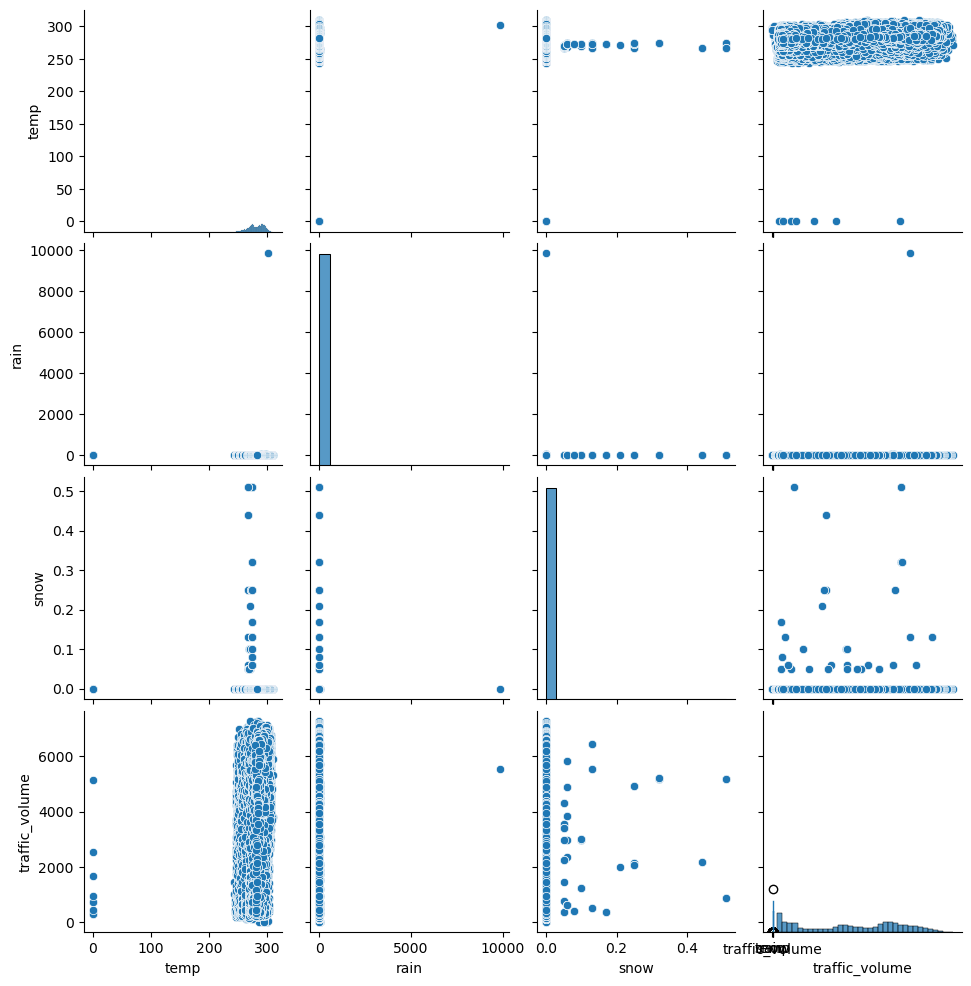

In [7]:
# Visualizations
cor = data.select_dtypes(include=['number']).corr()
sns.heatmap(cor)
sns.pairplot(data)
data.boxplot()


In [8]:
# Feature engineering - extract datetime features
data[['year', 'month', 'day']] = data['date'].str.split('-', expand=True)
data[['hours', 'minutes', 'seconds']] = data['Time'].str.split(':', expand=True)

In [9]:
data['year'] = pd.to_numeric(data['year'])
data['month'] = pd.to_numeric(data['month'])
data['day'] = pd.to_numeric(data['day'])
data['hours'] = pd.to_numeric(data['hours'])
data['minutes'] = pd.to_numeric(data['minutes'])
data['seconds'] = pd.to_numeric(data['seconds'])

In [10]:
# Drop original columns
data.drop(columns=['date', 'Time'], inplace=True)

In [11]:
# Prepare features and target
y = data['traffic_volume']
x = data.drop(columns=['traffic_volume'])

In [12]:
# Encode categorical variables properly
le_weather = LabelEncoder()
x['weather_encoded'] = le_weather.fit_transform(x['weather'])
x = x.drop('weather', axis=1)


In [13]:
# Get dummy variables for other categorical columns if any
x = pd.get_dummies(x, drop_first=True)

In [14]:
# Save column names before scaling
column_names = list(x.columns)

In [15]:
# Scale features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x = pd.DataFrame(x_scaled, columns=column_names)

In [16]:
print("Features shape:", x.shape)
print("Target shape:", y.shape)

Features shape: (48204, 20)
Target shape: (48204,)


In [17]:
# Save preprocessing objects and column info
with open('columns.json', 'w') as f:
    json.dump(column_names, f)

In [18]:
pickle.dump(scaler, open('scaler.pkl', 'wb'))
pickle.dump(le_weather, open('label_encoder.pkl', 'wb'))

In [19]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [22]:
# Initialize models with better parameters
models = {
    'Linear Regression': linear_model.LinearRegression(),
    'Decision Tree': tree.DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': ensemble.RandomForestRegressor(n_estimators=100, random_state=42, max_depth=15),
    'SVR': svm.SVR(kernel='rbf', C=100, gamma='scale'),
    'XGBoost': xgboost.XGBRegressor(random_state=42, n_estimators=100, max_depth=6)
}

In [23]:
# Train models
trained_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(x_train, y_train)
    trained_models[name] = model

Training Linear Regression...
Training Decision Tree...
Training Random Forest...
Training SVR...
Training XGBoost...


In [25]:
# Evaluate on training set
print("\n=== Training Set Performance ===")
train_scores = {}
for name, model in trained_models.items():
    pred = model.predict(x_train)
    r2 = metrics.r2_score(y_train, pred)
    mse = metrics.mean_squared_error(y_train, pred)
    rmse = np.sqrt(mse)
    train_scores[name] = {'r2': r2, 'rmse': rmse}
    print(f"{name}: R² = {r2:.4f}, RMSE = {rmse:.2f}")


=== Training Set Performance ===
Linear Regression: R² = 0.1327, RMSE = 1849.99
Decision Tree: R² = 0.8055, RMSE = 875.98
Random Forest: R² = 0.8980, RMSE = 634.38
SVR: R² = 0.6530, RMSE = 1170.12
XGBoost: R² = 0.8700, RMSE = 716.13


In [26]:
print("\n=== Test Set Performance ===")
test_scores = {}
for name, model in trained_models.items():
    pred = model.predict(x_test)
    r2 = metrics.r2_score(y_test, pred)
    mse = metrics.mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    test_scores[name] = {'r2': r2, 'rmse': rmse}
    print(f"{name}: R² = {r2:.4f}, RMSE = {rmse:.2f}")


=== Test Set Performance ===
Linear Regression: R² = 0.1393, RMSE = 1844.69
Decision Tree: R² = 0.7896, RMSE = 912.01
Random Forest: R² = 0.8271, RMSE = 826.83
SVR: R² = 0.6585, RMSE = 1161.97
XGBoost: R² = 0.8403, RMSE = 794.63


In [27]:
# Find best model
best_model_name = max(test_scores.keys(), key=lambda k: test_scores[k]['r2'])
best_model = trained_models[best_model_name]
print(f"\nBest model: {best_model_name}")
print(f"Test R²: {test_scores[best_model_name]['r2']:.4f}")
print(f"Test RMSE: {test_scores[best_model_name]['rmse']:.2f}")


Best model: XGBoost
Test R²: 0.8403
Test RMSE: 794.63


In [28]:
# Save best model
pickle.dump(best_model, open('best_model.pkl', 'wb'))

In [29]:
# Save model info
model_info = {
    'best_model_name': best_model_name,
    'test_scores': test_scores,
    'feature_columns': column_names
}

In [30]:
with open('model_info.json', 'w') as f:
    json.dump(model_info, f)

In [31]:
print("\nFiles saved:")
print("- best_model.pkl")
print("- scaler.pkl") 
print("- label_encoder.pkl")
print("- columns.json")
print("- model_info.json")


Files saved:
- best_model.pkl
- scaler.pkl
- label_encoder.pkl
- columns.json
- model_info.json
